In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
### データファイルの読込
df_mig = pd.read_csv('./data/00200523_migration.csv', parse_dates=['datetime'])
df_pop = pd.read_csv('./data/00200241_population.csv', parse_dates=['datetime'])
df_wag = pd.read_csv('./data/00450091_wage.csv', parse_dates=['datetime'])
df_idt = pd.read_csv('./data/00550010_industrial.csv', parse_dates=['datetime'])
df_ret = pd.read_csv('./data/00550020_retail.csv', parse_dates=['datetime'])
pd.set_option("display.max_columns", 100)
df_mig.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal
0,2005-04-01,北海道,11705,13894,52526
1,2005-04-01,青森県,4230,6603,5525
2,2005-04-01,岩手県,4082,5984,4840


In [3]:
### データの前処理(1):年次データ化
df_list = []
for prefecture in df_mig['prefecture'].unique():
    df_tmp = df_mig[df_mig['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').sum()
    df_tmp.reset_index(inplace=True)
    df_tmp.insert(1, 'prefecture', prefecture)
    df_list.append(df_tmp)
df_mig_year = pd.concat(df_list)

df_pop_year = df_pop

df_wag_year = df_wag

df_list = []
for prefecture in df_idt['prefecture'].unique():
    df_tmp = df_idt[df_idt['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').interpolate()
    df_tmp.reset_index(inplace=True)
    df_tmp['prefecture'] = prefecture
    df_list.append(df_tmp)
df_idt_year = pd.concat(df_list)

df_list = []
for prefecture in df_ret['prefecture'].unique():
    df_tmp = df_ret[df_ret['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').interpolate()
    df_tmp.reset_index(inplace=True)
    df_tmp['prefecture'] = prefecture
    df_list.append(df_tmp)
df_ret_year = pd.concat(df_list)

In [4]:
### データの前処理(2):データ結合
dt_all_start = datetime.datetime.strptime('2008-01-01', '%Y-%m-%d')
dt_all_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_all = df_mig_year[((df_mig_year['datetime'] >= dt_all_start) & (df_mig_year['datetime'] <= dt_all_end))]
df_all = df_all.merge(df_pop_year, how='left')
df_all = df_all.merge(df_wag_year, how='left')
df_all = df_all.merge(df_idt_year, how='left')
df_all = df_all.merge(df_ret_year, how='left')
df_all.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal,pop_male,pop_female,pop_sum,pop_households,wag_age,wag_salary,wag_bonus,wag_workers,idt_offices,idt_employees,idt_salaries,idt_costs,idt_sales,ret_offices,ret_employees,ret_sales
0,2008-01-01,北海道,49497,70626,220787,2648735,2923035,5571770,2618005,41.6,299300,767600,814020,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2009-01-01,北海道,51598,63776,214139,2631725,2911831,5543556,2637145,42.0,278300,695700,840210,6136.0,177113.0,5.838610e+11,3.344335e+12,5.202551e+12,57847.6,460521.8,1.688161e+13
2,2010-01-01,北海道,48784,57421,205297,2618969,2901925,5520894,2654310,42.2,284500,671500,748130,5931.0,173973.0,5.766830e+11,3.937932e+12,5.952864e+12,57653.4,458886.2,1.641274e+13


In [5]:
### データの前処理(3):ラグデータ化
df_list = []
for prefecture in df_all['prefecture'].unique():
    df_tmp = df_all[df_all['prefecture'] == prefecture]
    df_tmp = df_tmp.shift(1)
    df_list.append(df_tmp)
df_all_lag1 = pd.concat(df_list)
df_all_lag1.rename(columns=lambda x: x + '_lag1', inplace=True)
df_all_lag = pd.concat([df_all.iloc[:, 0:3], df_all_lag1.iloc[:,2:24]], axis=1)
df_all_lag.dropna(inplace=True)
df_all_lag.reset_index(drop=True, inplace=True)
df_all_lag.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1
0,2009-01-01,北海道,51598,49497.0,70626.0,220787.0,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2010-01-01,北海道,48784,51598.0,63776.0,214139.0,2631725.0,2911831.0,5543556.0,2637145.0,42.0,278300.0,695700.0,840210.0,6136.0,177113.0,5.838610e+11,3.344335e+12,5.202551e+12,57847.6,460521.8,1.688161e+13
2,2011-01-01,北海道,51998,48784.0,57421.0,205297.0,2618969.0,2901925.0,5520894.0,2654310.0,42.2,284500.0,671500.0,748130.0,5931.0,173973.0,5.766830e+11,3.937932e+12,5.952864e+12,57653.4,458886.2,1.641274e+13


In [6]:
### データの前処理(4):データスケーリング
df_all_list = list()
df_all_list.append(df_all_lag['datetime'])
df_all_list.append(df_all_lag['prefecture'])
df_all_list.append(df_all_lag['mig_in'])
for i in range(3, df_all_lag.shape[1]):
    sc = StandardScaler()
    a = df_all_lag.iloc[:, i]
    a = np.array(a, dtype='float32').reshape(-1, 1)
    sc.partial_fit(a)
    a = sc.transform(a)
    a = pd.DataFrame(a, columns=[df_all_lag.columns[i]])
    a = df_all_list.append(a)
df_all_sc = pd.concat(df_all_list, 1)
df_all_sc.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1
0,2009-01-01,北海道,51598,-0.018554,0.324887,2.103498,1.031047,1.181832,1.107231,1.216212,-0.169115,0.131174,0.334509,0.635823,0.395612,0.151758,-0.116574,-0.011734,-0.047721,1.009716,0.76242,0.262148
1,2010-01-01,北海道,48784,0.011468,0.212663,2.017105,1.017830,1.173225,1.096329,1.231986,0.448246,-0.521113,-0.132232,0.681597,0.287714,0.093090,-0.174385,-0.133366,-0.153472,1.002628,0.75684,0.243669
2,2011-01-01,北海道,51998,-0.028743,0.108548,1.902201,1.007919,1.165616,1.087573,1.246131,0.756927,-0.328533,-0.289327,0.520663,0.241824,0.071447,-0.184351,-0.001945,-0.042478,0.995540,0.75126,0.225190


In [7]:
### データ前処理(5):学習用データ化
dt_train_start = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
dt_train_end = datetime.datetime.strptime('2012-01-01', '%Y-%m-%d')
dt_validation_start = datetime.datetime.strptime('2013-01-01', '%Y-%m-%d')
dt_validation_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_train = df_all_sc[((df_all_sc['datetime'] >= dt_train_start) & (df_all_sc['datetime'] <= dt_train_end))]
df_train_rand = df_train.reindex(np.random.permutation(df_train.index)).reset_index(drop=True)
train_x = np.array(df_train_rand.iloc[:, 3:].as_matrix(), dtype='float32')
train_y = np.array(df_train_rand.iloc[:, 2].as_matrix(), dtype='float32')
df_validation = df_all_sc[((df_all_sc['datetime'] >= dt_validation_start) & (df_all_sc['datetime'] <= dt_validation_end))]
df_validation_rand = df_validation.reindex(np.random.permutation(df_validation.index)).reset_index(drop=True)
validation_x = np.array(df_validation_rand.iloc[:, 3:].as_matrix(), dtype='float32')
validation_y = np.array(df_validation_rand.iloc[:, 2].as_matrix(), dtype='float32')

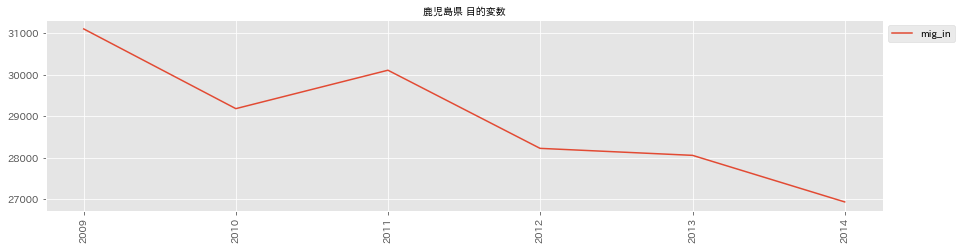

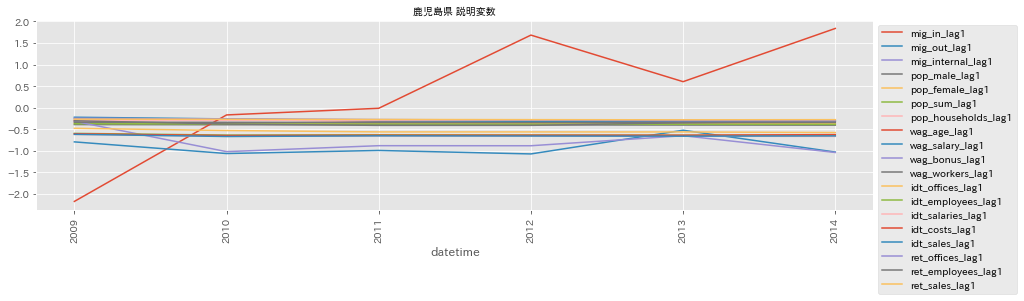

In [8]:
### 事前のデータ確認(サンプル)
prefecture = '鹿児島県'
df_tmp = df_all_sc[df_all_sc['prefecture'] == prefecture]
x = df_tmp['datetime']
y = df_tmp['mig_in']
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 目的変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

df_tmp.set_index('datetime', inplace=True)
df_tmp = df_tmp.iloc[:, 2:]
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
df_tmp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 説明変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
### DL学習設定
n_in = df_all_sc.shape[1] -3 # 19
n_hiddens = [200, 200]
n_out = 1
activation = 'relu'

def weight_variable(shape, name=None):
    return np.sqrt(2000.0 / shape[0]) * np.random.normal(size=shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Activation(activation))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('relu'))
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['mae'])

### DL学習
epochs = 500
batch_size = 30
hist = model.fit(train_x, train_y, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_x, validation_y),
                 callbacks=[early_stopping])

Train on 188 samples, validate on 94 samples
Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 7268400503.8298 - mean_absolute_error: 50293.0501 - val_loss: 7699347439.6596 - val_mean_absolute_error: 50632.3383
Epoch 2/500
188/188 [==============================] - 0s 175us/step - loss: 7258000637.2766 - mean_absolute_error: 50261.9753 - val_loss: 7688793199.6596 - val_mean_absolute_error: 50602.7266
Epoch 3/500
188/188 [==============================] - 0s 273us/step - loss: 7248778144.6809 - mean_absolute_error: 50228.8123 - val_loss: 7676785056.6809 - val_mean_absolute_error: 50568.8231
Epoch 4/500
188/188 [==============================] - 0s 228us/step - loss: 7239235129.1915 - mean_absolute_error: 50197.2474 - val_loss: 7667215719.4894 - val_mean_absolute_error: 50539.5384
Epoch 5/500
188/188 [==============================] - 0s 229us/step - loss: 7230438116.7660 - mean_absolute_error: 50165.4719 - val_loss: 7654653935.6596 - val_mean_absolute_error: 505

188/188 [==============================] - 0s 208us/step - loss: 6630850479.6596 - mean_absolute_error: 47679.4681 - val_loss: 6972835912.1702 - val_mean_absolute_error: 48252.3791
Epoch 44/500
188/188 [==============================] - 0s 167us/step - loss: 6596340368.3404 - mean_absolute_error: 47564.7808 - val_loss: 6947356829.9574 - val_mean_absolute_error: 48140.3017
Epoch 45/500
188/188 [==============================] - 0s 164us/step - loss: 6592130163.7447 - mean_absolute_error: 47450.9191 - val_loss: 6917441011.7447 - val_mean_absolute_error: 48032.6932
Epoch 46/500
188/188 [==============================] - 0s 202us/step - loss: 6558550127.6596 - mean_absolute_error: 47338.5967 - val_loss: 6895609606.8085 - val_mean_absolute_error: 47956.4733
Epoch 47/500
188/188 [==============================] - 0s 193us/step - loss: 6522861294.2979 - mean_absolute_error: 47217.1085 - val_loss: 6864237558.4681 - val_mean_absolute_error: 47837.4858
Epoch 48/500
188/188 [=====================

188/188 [==============================] - 0s 169us/step - loss: 5367396754.7234 - mean_absolute_error: 41178.3245 - val_loss: 5567102058.2128 - val_mean_absolute_error: 42428.3589
Epoch 86/500
188/188 [==============================] - 0s 204us/step - loss: 5256597993.1915 - mean_absolute_error: 41056.4498 - val_loss: 5506540432.3404 - val_mean_absolute_error: 42225.0696
Epoch 87/500
188/188 [==============================] - 0s 193us/step - loss: 5178027506.3830 - mean_absolute_error: 40815.1596 - val_loss: 5431466841.8723 - val_mean_absolute_error: 41952.6928
Epoch 88/500
188/188 [==============================] - 0s 197us/step - loss: 5150898407.4894 - mean_absolute_error: 40671.8796 - val_loss: 5415945503.3191 - val_mean_absolute_error: 41791.8918
Epoch 89/500
188/188 [==============================] - 0s 194us/step - loss: 5143431380.4255 - mean_absolute_error: 40478.8397 - val_loss: 5390011895.8298 - val_mean_absolute_error: 41596.2613
Epoch 90/500
188/188 [=====================

188/188 [==============================] - 0s 208us/step - loss: 3742606540.4255 - mean_absolute_error: 32144.7552 - val_loss: 3749185453.6170 - val_mean_absolute_error: 33285.2730
Epoch 128/500
188/188 [==============================] - 0s 178us/step - loss: 3877887842.0426 - mean_absolute_error: 32194.5174 - val_loss: 3733927102.6383 - val_mean_absolute_error: 33148.3599
Epoch 129/500
188/188 [==============================] - 0s 176us/step - loss: 3638723540.0851 - mean_absolute_error: 31797.3193 - val_loss: 3705881423.6596 - val_mean_absolute_error: 32936.5844
Epoch 130/500
188/188 [==============================] - 0s 222us/step - loss: 3621276473.8723 - mean_absolute_error: 31587.9682 - val_loss: 3629159583.3191 - val_mean_absolute_error: 32492.2026
Epoch 131/500
188/188 [==============================] - 0s 234us/step - loss: 3631223154.0426 - mean_absolute_error: 31343.7905 - val_loss: 3550198201.1915 - val_mean_absolute_error: 32028.1451
Epoch 132/500
188/188 [================

188/188 [==============================] - 0s 196us/step - loss: 2158562171.9149 - mean_absolute_error: 23083.3895 - val_loss: 2333788857.1915 - val_mean_absolute_error: 22758.3937
Epoch 170/500
188/188 [==============================] - 0s 154us/step - loss: 2488750487.4043 - mean_absolute_error: 22224.8273 - val_loss: 2229398517.7872 - val_mean_absolute_error: 22309.4043
Epoch 171/500
188/188 [==============================] - 0s 190us/step - loss: 2257256845.5319 - mean_absolute_error: 22397.7648 - val_loss: 2158934928.6809 - val_mean_absolute_error: 22122.7937
Epoch 172/500
188/188 [==============================] - 0s 167us/step - loss: 2365150526.6383 - mean_absolute_error: 22358.9500 - val_loss: 2092866702.6383 - val_mean_absolute_error: 21826.6377
Epoch 173/500
188/188 [==============================] - 0s 204us/step - loss: 2455506746.8085 - mean_absolute_error: 23211.3701 - val_loss: 2081616597.7872 - val_mean_absolute_error: 21615.2283
Epoch 174/500
188/188 [================

188/188 [==============================] - 0s 175us/step - loss: 1433237054.9894 - mean_absolute_error: 16712.4739 - val_loss: 1350430553.1383 - val_mean_absolute_error: 15978.1811
Epoch 212/500
188/188 [==============================] - 0s 172us/step - loss: 1686378747.9149 - mean_absolute_error: 16999.7444 - val_loss: 1307466488.3005 - val_mean_absolute_error: 15801.5690
Epoch 213/500
188/188 [==============================] - 0s 208us/step - loss: 1348839454.4255 - mean_absolute_error: 15797.0950 - val_loss: 1380092726.9787 - val_mean_absolute_error: 16551.4520
Epoch 214/500
188/188 [==============================] - 0s 197us/step - loss: 1364395490.1383 - mean_absolute_error: 14763.4044 - val_loss: 1318290755.4934 - val_mean_absolute_error: 15821.6343
Epoch 215/500
188/188 [==============================] - 0s 206us/step - loss: 1578531429.8351 - mean_absolute_error: 15576.6648 - val_loss: 1290532522.5239 - val_mean_absolute_error: 15472.1196
Epoch 216/500
188/188 [================

188/188 [==============================] - 0s 181us/step - loss: 857613774.7766 - mean_absolute_error: 12199.1105 - val_loss: 832064968.1436 - val_mean_absolute_error: 12737.6576
Epoch 254/500
188/188 [==============================] - 0s 181us/step - loss: 677044568.8511 - mean_absolute_error: 13204.3166 - val_loss: 769349942.8777 - val_mean_absolute_error: 11839.4628
Epoch 255/500
188/188 [==============================] - 0s 199us/step - loss: 865590059.1702 - mean_absolute_error: 12895.7553 - val_loss: 811028898.7267 - val_mean_absolute_error: 12262.2126
Epoch 256/500
188/188 [==============================] - 0s 193us/step - loss: 1005049581.1383 - mean_absolute_error: 16036.6326 - val_loss: 940417428.2128 - val_mean_absolute_error: 13857.3752
Epoch 257/500
188/188 [==============================] - 0s 189us/step - loss: 1333150959.9149 - mean_absolute_error: 16523.1226 - val_loss: 1169838451.0638 - val_mean_absolute_error: 16613.1316
Epoch 258/500
188/188 [=======================

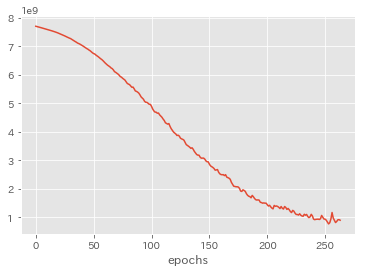

94/94 [==============================] - 0s 77us/step
[899171740.9361702, 14329.598601645612]


In [11]:
### 学習過程の確認
val_loss = hist.history['val_loss']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss')
plt.xlabel('epochs')
plt.show()

print(model.evaluate(validation_x, validation_y))

In [12]:
### モデルを用いた予測データの作成
train_x = np.array(df_train.iloc[:, 3:].as_matrix(), dtype='float32')
validation_x = np.array(df_validation.iloc[:, 3:].as_matrix(), dtype='float32')
pred_train = model.predict_proba(train_x) 
pred_validation = model.predict_proba(validation_x)
pred = np.concatenate([pred_train, pred_validation])
df_pred = pd.DataFrame(pred, columns=['mig_in_pred'])
df_pred = pd.concat([df_all_sc.iloc[:, 0:3], df_pred], axis=1)
df_pred.head(3)

,datetime,prefecture,mig_in,mig_in_pred
0,2009-01-01,北海道,51598,44019.191406
1,2010-01-01,北海道,48784,44397.308594
2,2011-01-01,北海道,51998,42274.277344


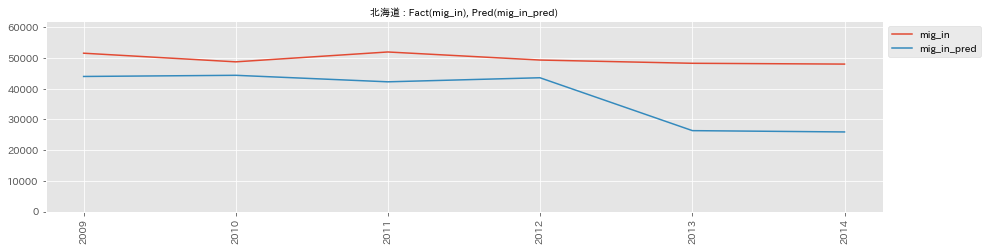

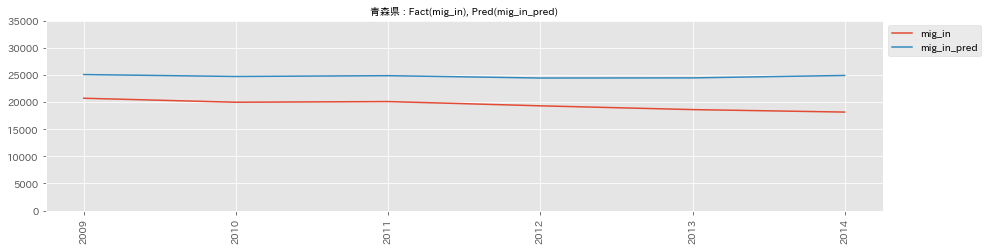

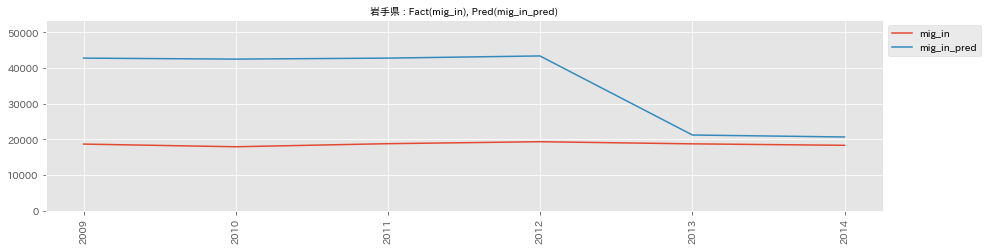

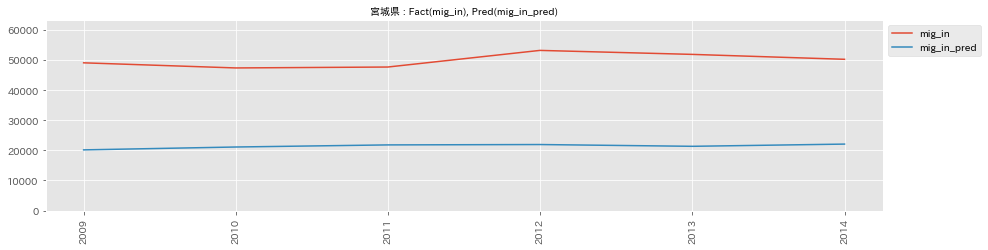

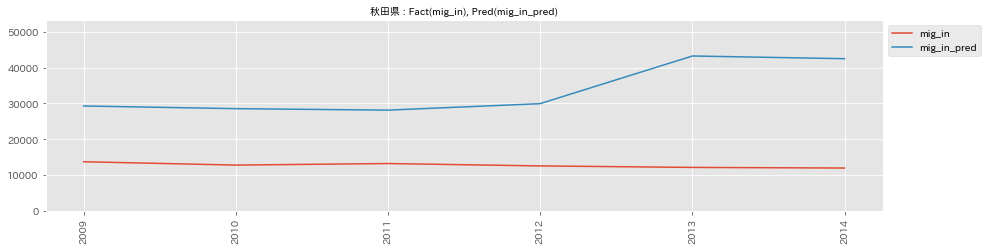

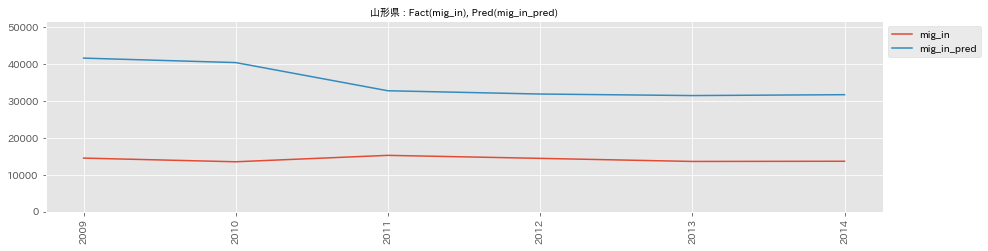

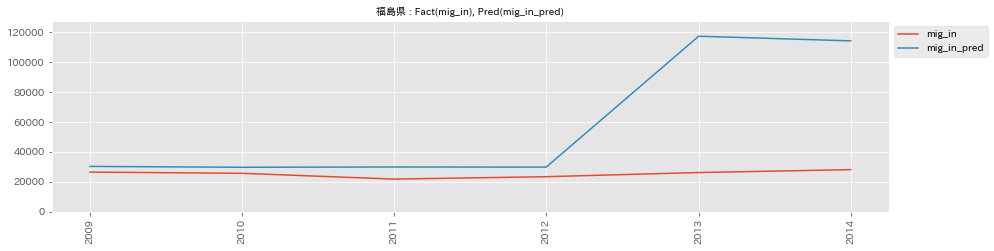

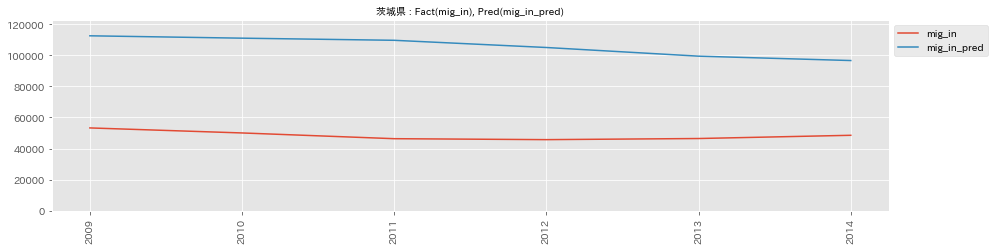

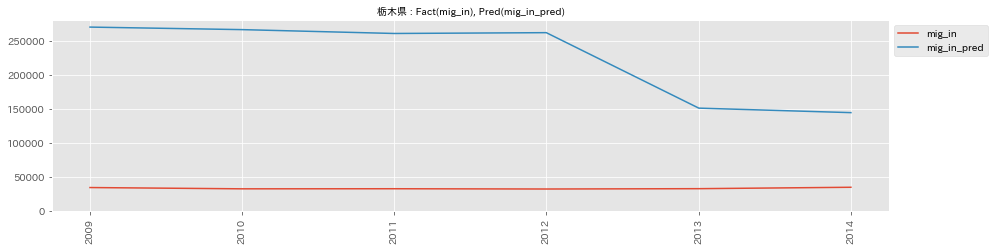

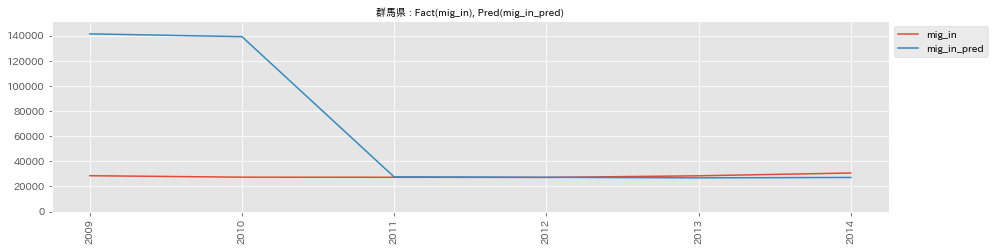

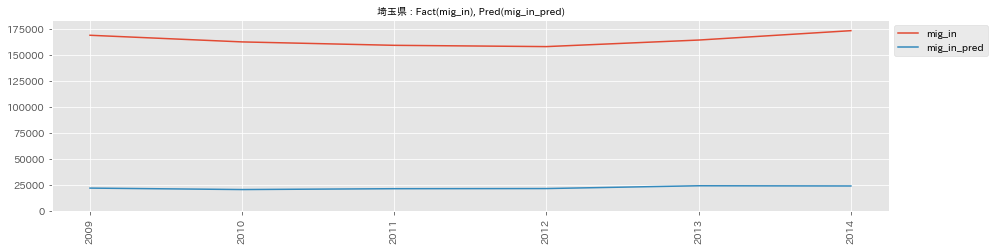

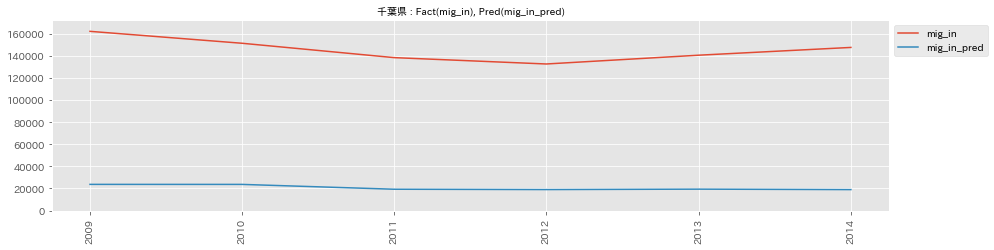

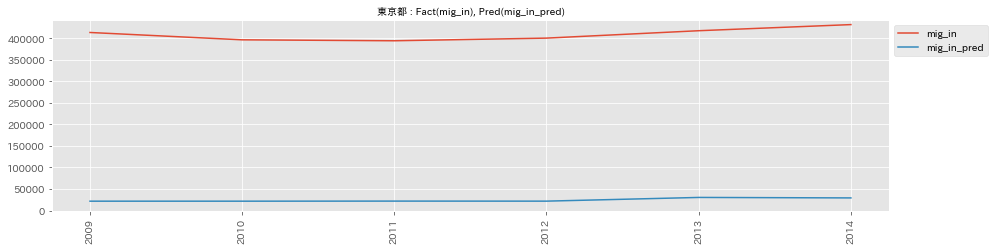

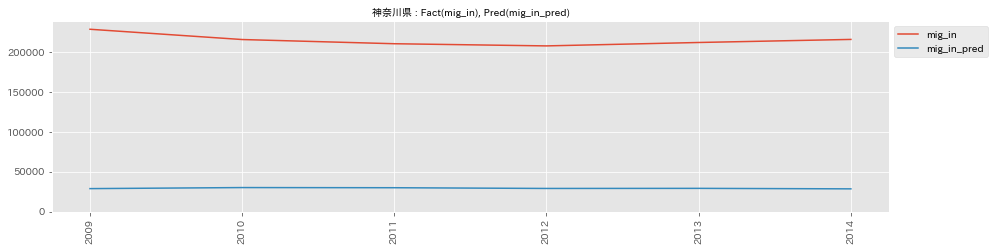

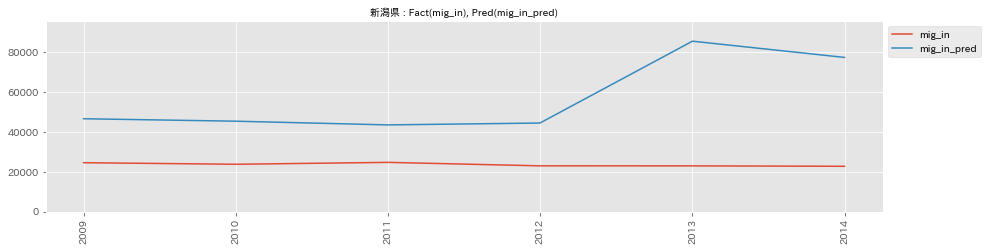

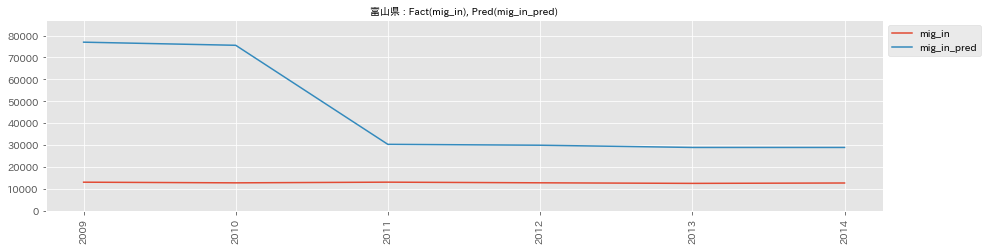

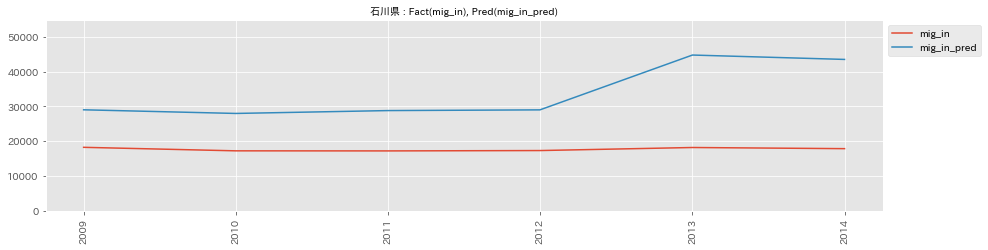

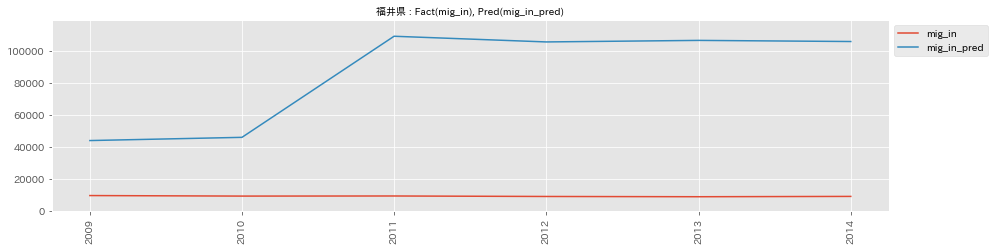

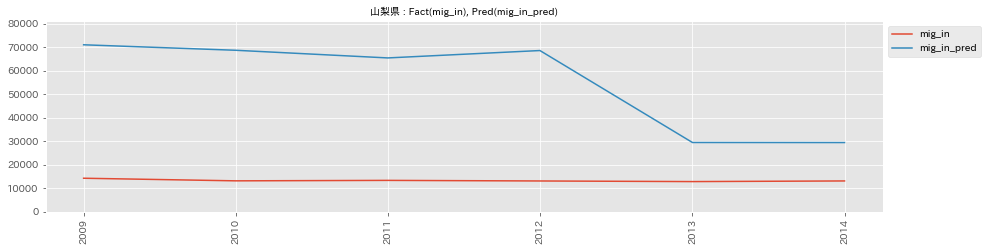

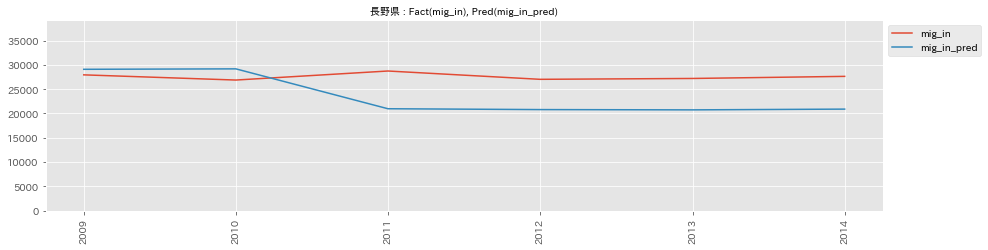

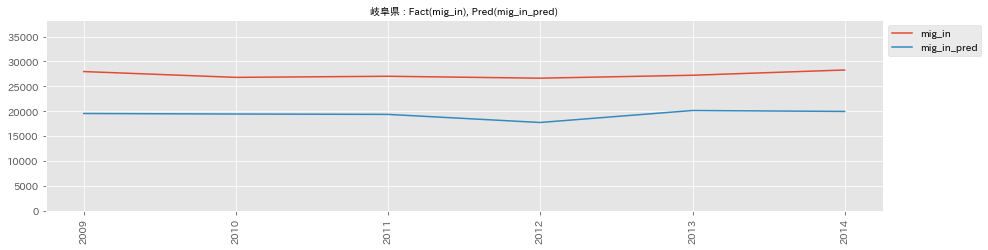

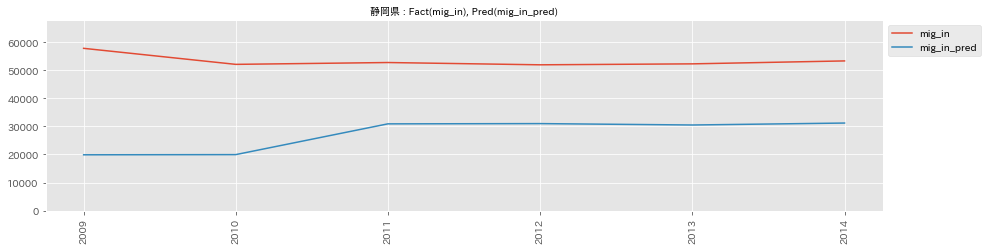

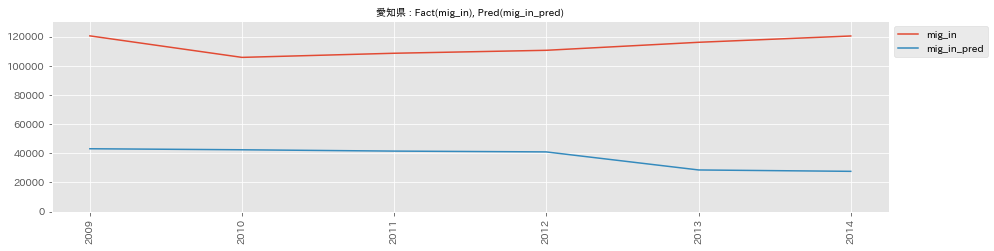

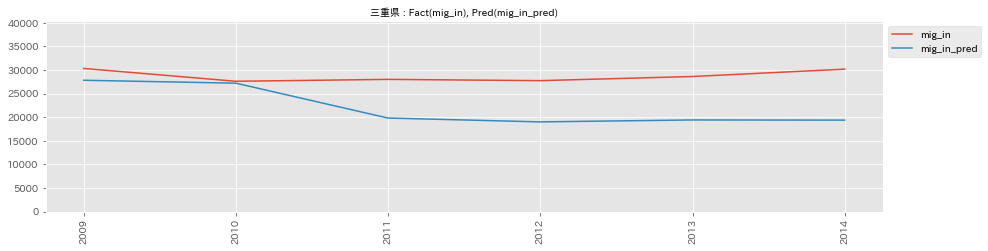

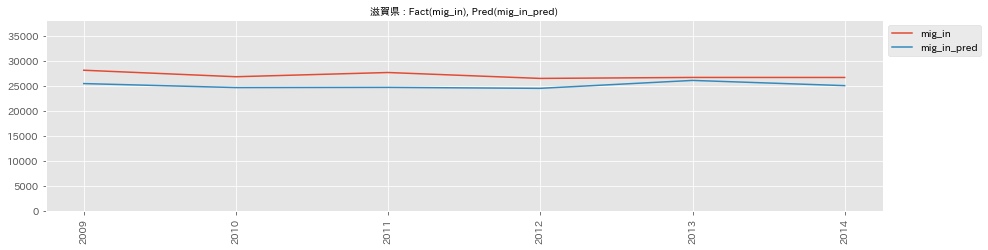

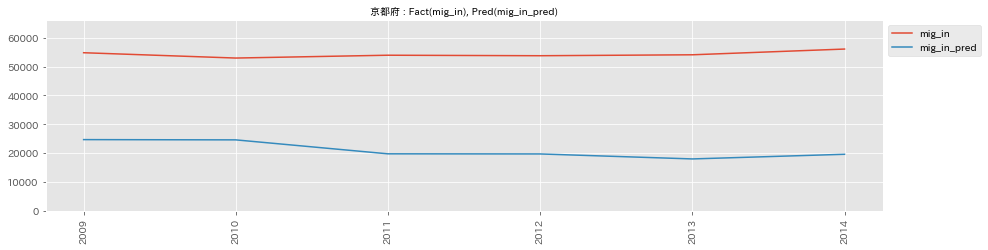

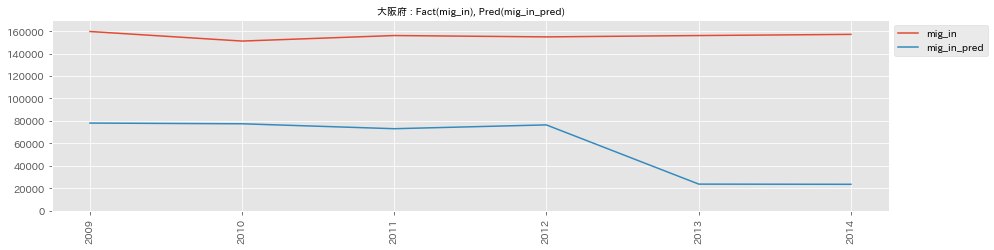

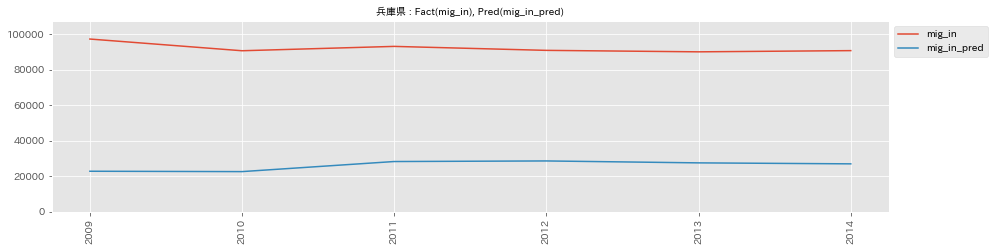

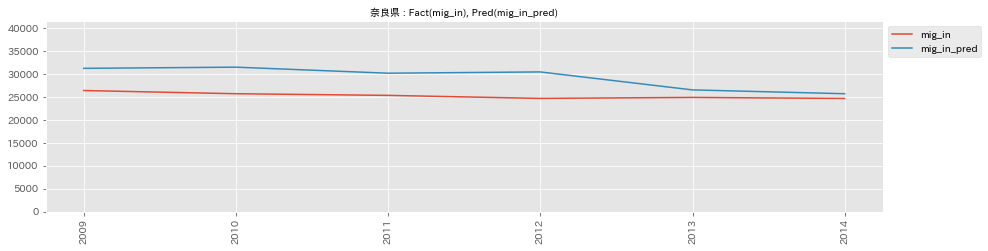

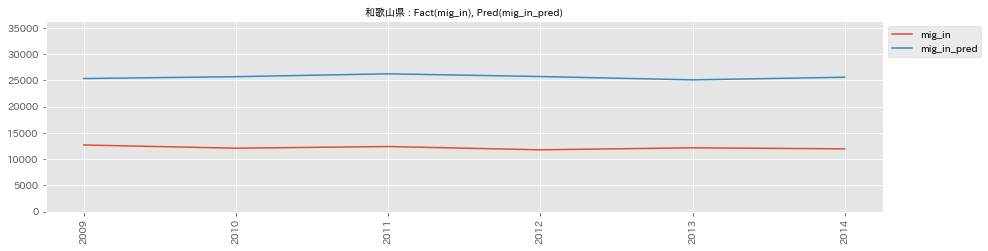

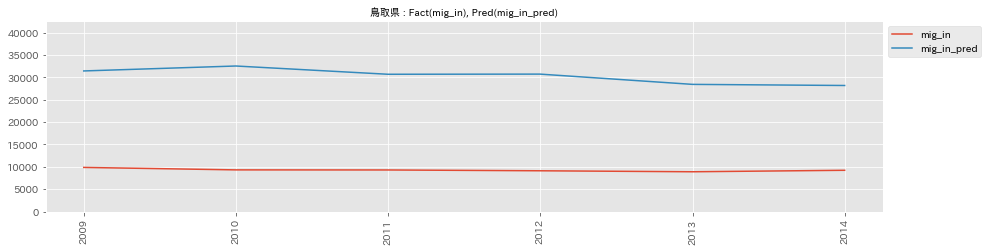

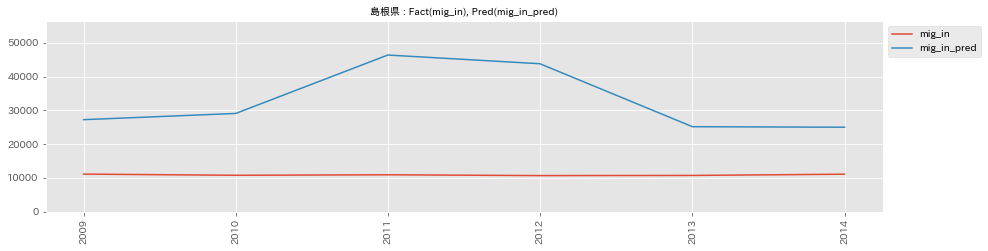

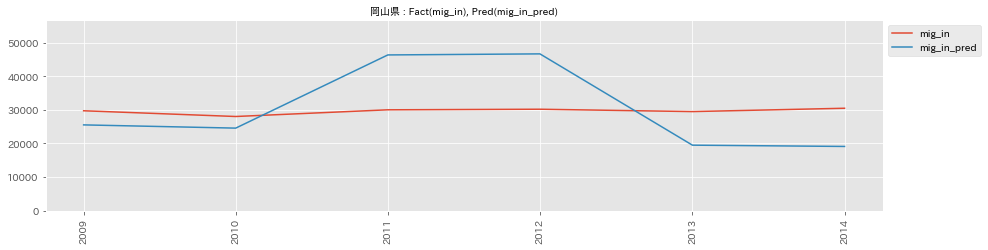

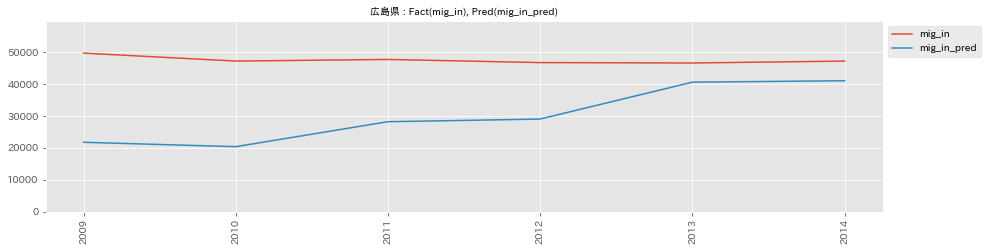

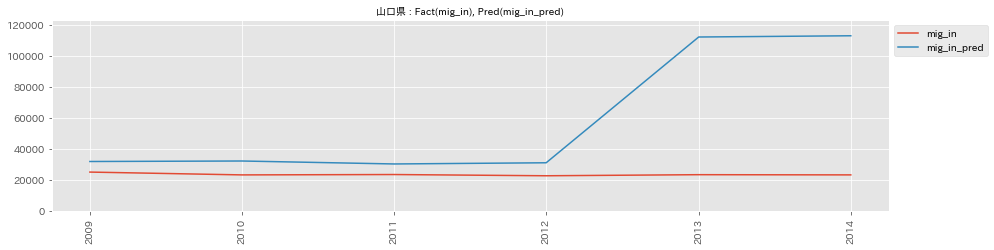

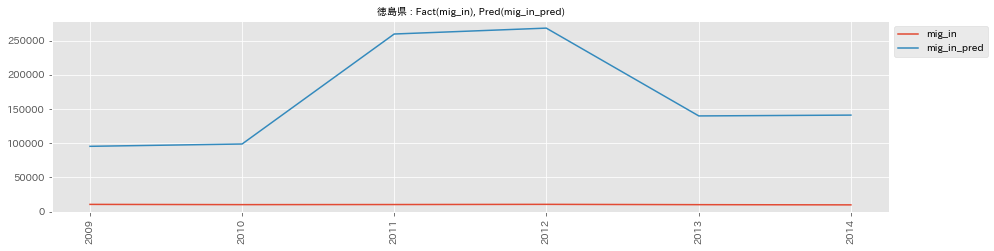

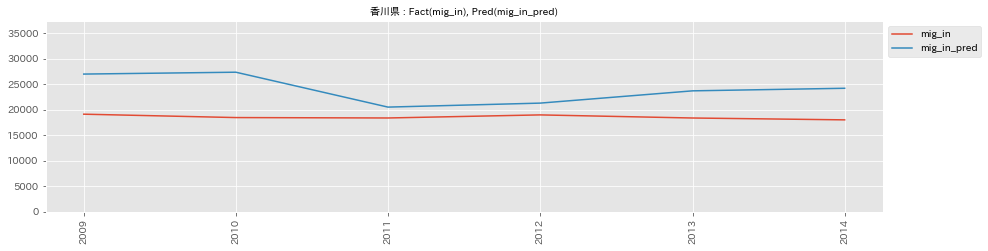

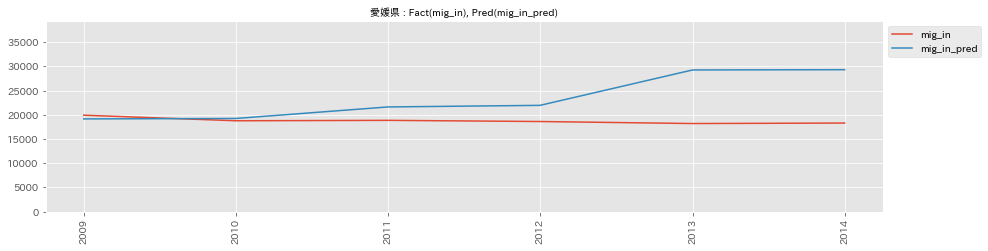

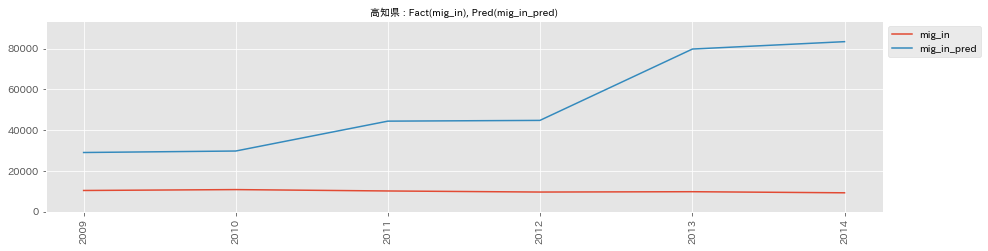

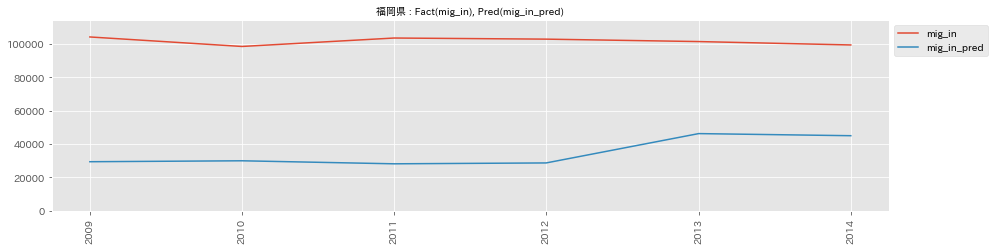

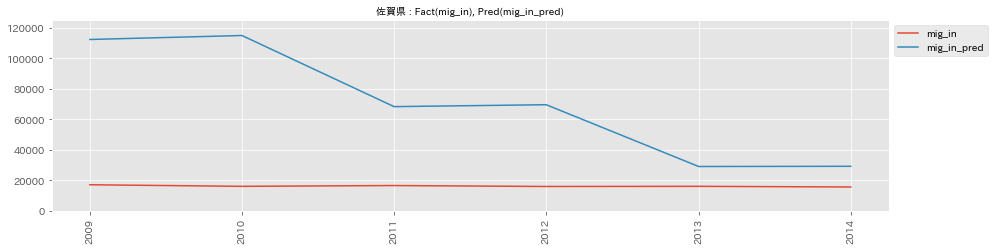

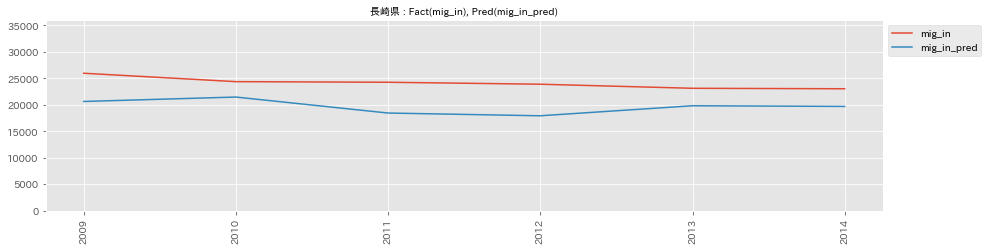

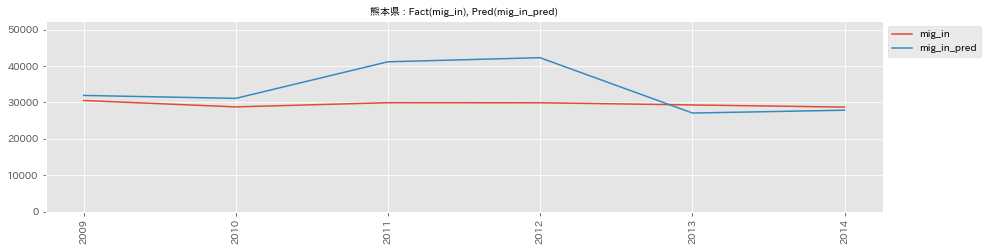

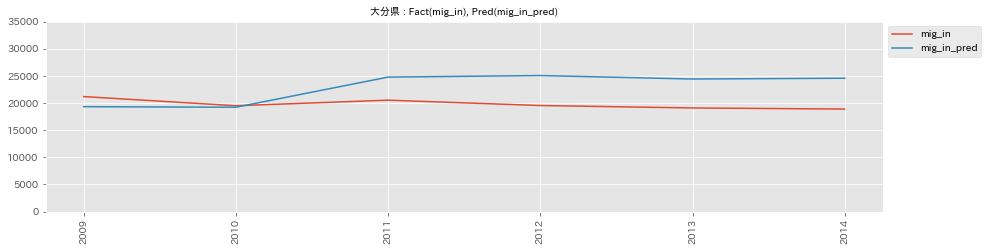

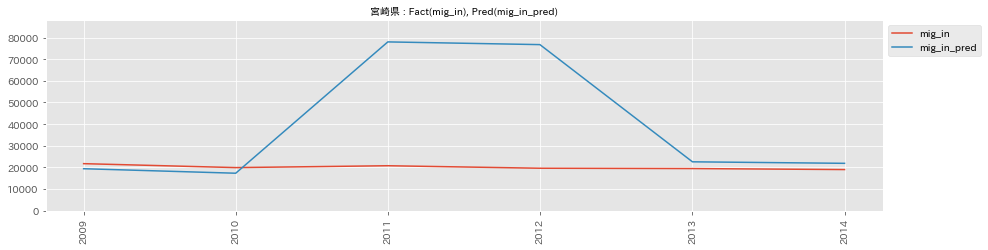

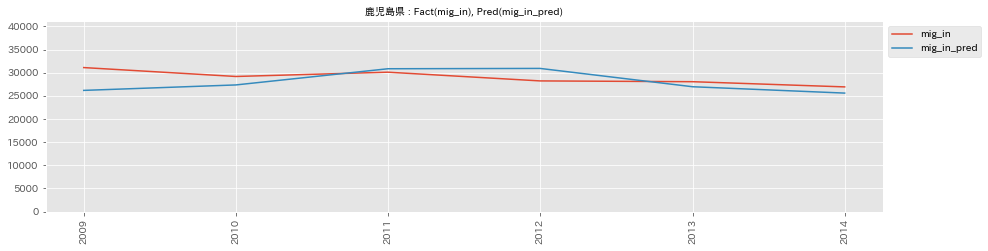

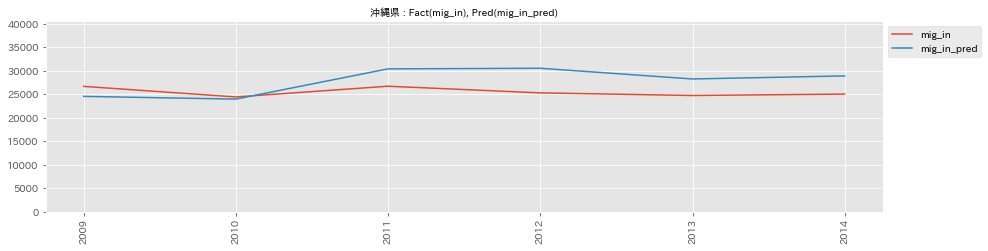

In [13]:
### 予測データの確認(可視化)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
for prefecture in df_pred['prefecture'].unique():
    df_tmp = df_pred[df_pred['prefecture'] == prefecture]
    x = df_tmp['datetime']
    y1 = df_tmp['mig_in']
    y2 = df_tmp['mig_in_pred']
    fig = plt.figure(figsize=(15,3.5))
    ax = fig.add_subplot(111)
    ax.plot(x, y1)
    ax.plot(x, y2)
    plt.ylim(0, max(y1.max(), y2.max()) + 10000)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(prefecture + ' : Fact(mig_in), Pred(mig_in_pred)', fontsize=10)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()